## Introducción

El objetivo de este proyecto es armar un sistema de reconocimiento de patrones para ser utilizado en un sistema empotrado, específicamente en el dispositivo Jetson Nano™ de Nvidia®.

La red neuronal seleccionada para este propósito es la Red Residual Profunda (*Deep Residual Network*).  Ésta se caracteriza por usar los valores originales en algunas capas de la red neuronal, cuando en las otras redes los valores originales únicamente ingresan a la primera capa de la red.  La figura 1 muestra un ejemplo del flujo de la información a través de tres capas de una red residual.

La principal ventaja de una red neuronal residual es la preservación de los gradientes indiferentemente de la profundidad de la red.

<div>
    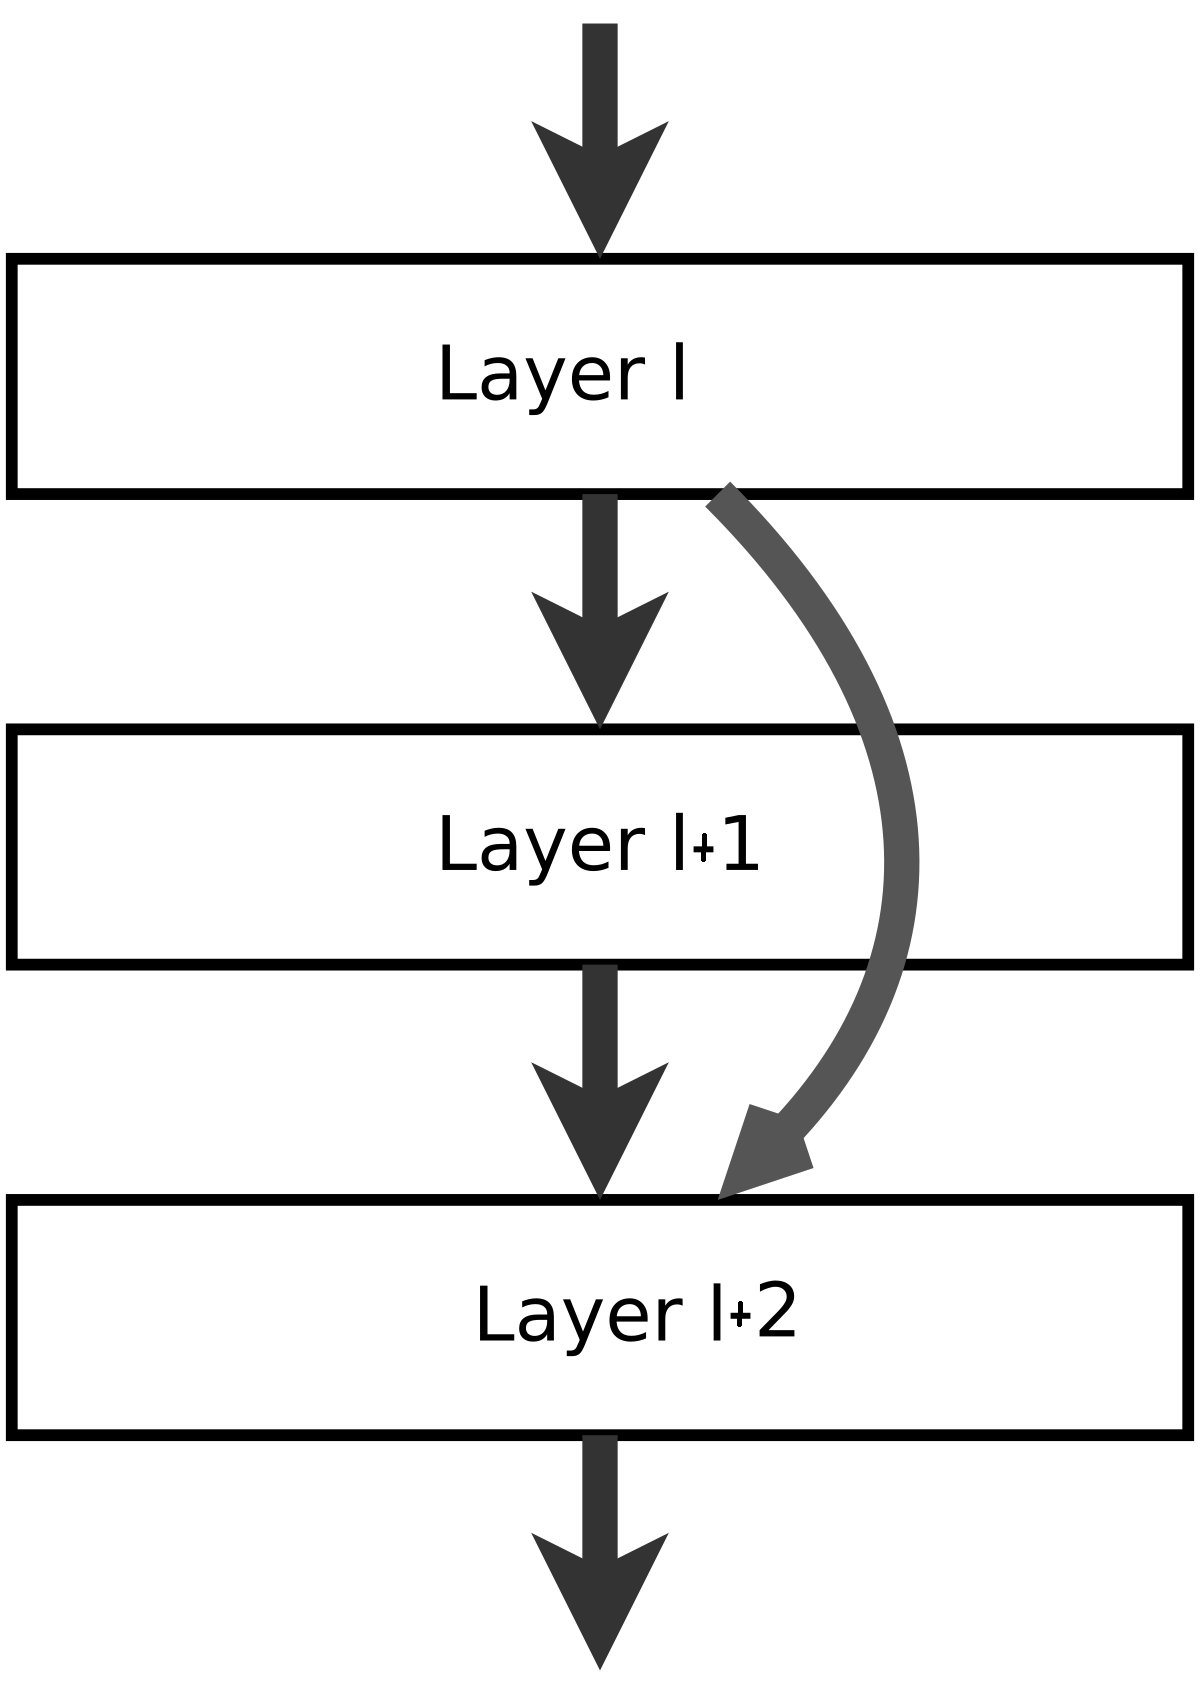
</div>
<Center>Figura 1. Ejemplo del flujo de una red residual de tres capas.</Center>

Debido a los requrimientos computacionales altos para el aprendizaje automático, se recomienda el uso de una computadora para el desarrollo del sistema de reconocimiento de patrones en una computadora ajena a la Jetson Nano™.  Adicionalmente, es recomendable utilizar una computadora con GPU incorporada para agilizar el proceso de entrenamiento del sistema de reconocimiento de patrones.

Para este proyecto, se elige identificar la clase de carros basados en imágenes y se utilizarán los algoritmos ResNet, de los cuales existen diferentes versiones que indican el nivel de profundidad.  Comúnmente se emplea el lenguaje <I>Python</I> por su facilidad de programación.  Se evaluaron las versiones ResNet50, ResNet101 y ResNet150.  Por rapidez, se elige la versión de ResNet50.  Las imágenes se obtuvieron de "<I>Cars Dataset</I>" de la Universidad de Stanford (https://ai.stanford.edu/~jkrause/cars/car_dataset.html).

El código utilizado está basado en el código de foamliu de GitHub (https://github.com/foamliu/Car-Recognition).  Éste utiliza paquetes como Keras y OpenCV.  Inicialmente, se debe descargar las imágenes en archivos <B>tgz</B> en una carpeta de trabajo, donde adicionalmente van los códigos del sistema de reconocimiento de patrones.

Posteriormente, se realiza un pre-procesado a los datos para separarlos en conjuntos de entrenamiento (<I>train</I>) y de prueba (<I>test</I>).  El código de pre-procesado es el siguiente:

In [3]:
import tarfile
import scipy.io
import numpy as np
import os
import cv2 as cv
import shutil
import random
#from console_progressbar import ProgressBar


def ensure_folder(folder):
    if not os.path.exists(folder):
        os.makedirs(folder)


def save_train_data(fnames, labels, bboxes):
    src_folder = 'cars_train'
    num_samples = len(fnames)

    train_split = 0.8
    num_train = int(round(num_samples * train_split))
    train_indexes = random.sample(range(num_samples), num_train)

    pb = ProgressBar(total=100, prefix='Save train data', suffix='', decimals=3, length=50, fill='=')

    for i in range(num_samples):
        fname = fnames[i]
        label = labels[i]
        (x1, y1, x2, y2) = bboxes[i]

        src_path = os.path.join(src_folder, fname)
        src_image = cv.imread(src_path)
        height, width = src_image.shape[:2]
        # margins of 16 pixels
        margin = 16
        x1 = max(0, x1 - margin)
        y1 = max(0, y1 - margin)
        x2 = min(x2 + margin, width)
        y2 = min(y2 + margin, height)
        #print("{} -> {}".format(fname, label))
        pb.print_progress_bar((i + 1) * 100 / num_samples)

        if i in train_indexes:
            dst_folder = 'data/train'
        else:
            dst_folder = 'data/valid'

        dst_path = os.path.join(dst_folder, label)
        if not os.path.exists(dst_path):
            os.makedirs(dst_path)
        dst_path = os.path.join(dst_path, fname)

        crop_image = src_image[y1:y2, x1:x2]
        dst_img = cv.resize(src=crop_image, dsize=(img_height, img_width))
        cv.imwrite(dst_path, dst_img)


def save_test_data(fnames, bboxes):
    src_folder = 'cars_test'
    dst_folder = 'data/test'
    num_samples = len(fnames)

    pb = ProgressBar(total=100, prefix='Save test data', suffix='', decimals=3, length=50, fill='=')

    for i in range(num_samples):
        fname = fnames[i]
        (x1, y1, x2, y2) = bboxes[i]
        src_path = os.path.join(src_folder, fname)
        src_image = cv.imread(src_path)
        height, width = src_image.shape[:2]
        # margins of 16 pixels
        margin = 16
        x1 = max(0, x1 - margin)
        y1 = max(0, y1 - margin)
        x2 = min(x2 + margin, width)
        y2 = min(y2 + margin, height)
        #print(fname)
        pb.print_progress_bar((i + 1) * 100 / num_samples)

        dst_path = os.path.join(dst_folder, fname)
        crop_image = src_image[y1:y2, x1:x2]
        dst_img = cv.resize(src=crop_image, dsize=(img_height, img_width))
        cv.imwrite(dst_path, dst_img)


def process_train_data():
    print("Processing train data...")
    cars_annos = scipy.io.loadmat('devkit/cars_train_annos')
    annotations = cars_annos['annotations']
    annotations = np.transpose(annotations)

    fnames = []
    class_ids = []
    bboxes = []
    labels = []

    for annotation in annotations:
        bbox_x1 = annotation[0][0][0][0]
        bbox_y1 = annotation[0][1][0][0]
        bbox_x2 = annotation[0][2][0][0]
        bbox_y2 = annotation[0][3][0][0]
        class_id = annotation[0][4][0][0]
        labels.append('%04d' % (class_id,))
        fname = annotation[0][5][0]
        bboxes.append((bbox_x1, bbox_y1, bbox_x2, bbox_y2))
        class_ids.append(class_id)
        fnames.append(fname)

    labels_count = np.unique(class_ids).shape[0]
    print(np.unique(class_ids))
    print('The number of different cars is %d' % labels_count)

    save_train_data(fnames, labels, bboxes)


def process_test_data():
    print("Processing test data...")
    cars_annos = scipy.io.loadmat('devkit/cars_test_annos')
    annotations = cars_annos['annotations']
    annotations = np.transpose(annotations)

    fnames = []
    bboxes = []

    for annotation in annotations:
        bbox_x1 = annotation[0][0][0][0]
        bbox_y1 = annotation[0][1][0][0]
        bbox_x2 = annotation[0][2][0][0]
        bbox_y2 = annotation[0][3][0][0]
        fname = annotation[0][4][0]
        bboxes.append((bbox_x1, bbox_y1, bbox_x2, bbox_y2))
        fnames.append(fname)

    save_test_data(fnames, bboxes)


if __name__ == '__main__':
    # parameters
    img_width, img_height = 224, 224

    print('Extracting cars_train.tgz...')
    if not os.path.exists('cars_train'):
        with tarfile.open('cars_train.tgz', "r:gz") as tar:
            tar.extractall()
    print('Extracting cars_test.tgz...')
    if not os.path.exists('cars_test'):
        with tarfile.open('cars_test.tgz', "r:gz") as tar:
            tar.extractall()
    print('Extracting car_devkit.tgz...')
    if not os.path.exists('devkit'):
        with tarfile.open('car_devkit.tgz', "r:gz") as tar:
            tar.extractall()

    cars_meta = scipy.io.loadmat('devkit/cars_meta')
    class_names = cars_meta['class_names']  # shape=(1, 196)
    class_names = np.transpose(class_names)
    print('class_names.shape: ' + str(class_names.shape))
    print('Sample class_name: [{}]'.format(class_names[8][0][0]))

    ensure_folder('data/train')
    ensure_folder('data/valid')
    ensure_folder('data/test')

    process_train_data()
    process_test_data()

    # clean up
    shutil.rmtree('cars_train')
    shutil.rmtree('cars_test')
    # shutil.rmtree('devkit')

ModuleNotFoundError: No module named 'cv2'

El siguiente paso es ejecutar el código de entrenamiento definido como:

In [7]:
import keras
#from resnet_152 import resnet152_model
from resnet_50 import resnet50_model
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import CSVLogger, ModelCheckpoint, EarlyStopping
from keras.callbacks import ReduceLROnPlateau

img_width, img_height = 224, 224
num_channels = 3
train_data = 'data/train'
valid_data = 'data/valid'
num_classes = 196
num_train_samples = 6549
num_valid_samples = 1595
verbose = 1
batch_size = 16
num_epochs = 200
patience = 50

if __name__ == '__main__':
    # build a classifier model
    model = resnet50_model(img_height, img_width, num_channels, num_classes)

    # prepare data augmentation configuration
    train_data_gen = ImageDataGenerator(rotation_range=20.,
                                        width_shift_range=0.1,
                                        height_shift_range=0.1,
                                        zoom_range=0.2,
                                        horizontal_flip=True)
    valid_data_gen = ImageDataGenerator()
    # callbacks
    tensor_board = keras.callbacks.TensorBoard(log_dir='./logs', histogram_freq=0, write_graph=True, write_images=True)
    log_file_path = 'logs/training.log'
    csv_logger = CSVLogger(log_file_path, append=False)
    early_stop = EarlyStopping('val_acc', patience=patience)
    reduce_lr = ReduceLROnPlateau('val_acc', factor=0.1, patience=int(patience / 4), verbose=1)
    trained_models_path = 'models/model'
    model_names = trained_models_path + '.{epoch:02d}-{val_acc:.2f}.hdf5'
    model_checkpoint = ModelCheckpoint(model_names, monitor='val_acc', verbose=1, save_best_only=True)
    callbacks = [tensor_board, model_checkpoint, csv_logger, early_stop, reduce_lr]

    # generators
    train_generator = train_data_gen.flow_from_directory(train_data, (img_width, img_height), batch_size=batch_size,
                                                         class_mode='categorical')
    valid_generator = valid_data_gen.flow_from_directory(valid_data, (img_width, img_height), batch_size=batch_size,
                                                         class_mode='categorical')

    # fine tune the model
    model.fit_generator(
        train_generator,
        steps_per_epoch=num_train_samples / batch_size,
        validation_data=valid_generator,
        validation_steps=num_valid_samples / batch_size,
        epochs=num_epochs,
        callbacks=callbacks,
        verbose=verbose)

Fin


Ahora se procede a especificar el modelo deseado en model_weights_path en la línea 7 del código "utils.py":

In [ ]:
import cv2 as cv

#from resnet_152 import resnet152_model
from resnet_50 import resnet50_model

def load_model():
    model_weights_path = 'models/model.76-0.90.hdf5'
    img_width, img_height = 224, 224
    num_channels = 3
    num_classes = 196
    model = resnet50_model(img_height, img_width, num_channels, num_classes)
    model.load_weights(model_weights_path, by_name=True)
    return model


def draw_str(dst, target, s):
    x, y = target
    cv.putText(dst, s, (x + 1, y + 1), cv.FONT_HERSHEY_PLAIN, 1.0, (0, 0, 0), thickness=2, lineType=cv.LINE_AA)
    cv.putText(dst, s, (x, y), cv.FONT_HERSHEY_PLAIN, 1.0, (255, 255, 255), lineType=cv.LINE_AA)

Luego, simplemente se corre el siguiente código:

In [ ]:
# -*- coding: utf-8 -*-

import os

import matplotlib.pyplot as plt
import numpy as np
from keras.preprocessing import image
from sklearn.metrics import confusion_matrix
from tqdm import tqdm

from utils import load_model


def decode_predictions(preds, top=5):
    results = []
    for pred in preds:
        top_indices = pred.argsort()[-top:][::-1]
        result = [(class_names[i], pred[i]) for i in top_indices]
        result.sort(key=lambda x: x[1], reverse=True)
        results.append(result)
    return results


def predict(img_dir, model):
	img_files = []
	for root, dirs, files in os.walk(img_dir, topdown=False):
		for name in files:
			img_files.append(os.path.join(root, name))
	img_files = sorted(img_files)

	y_pred = []
	y_test = []

	for img_path in tqdm(img_files):
		# print(img_path)
		img = image.load_img(img_path, target_size=(224, 224))
		x = image.img_to_array(img)
		preds = model.predict(x[None, :, :, :])
		decoded = decode_predictions(preds, top=1)
		pred_label = decoded[0][0][0]
		# print(pred_label)
		y_pred.append(pred_label)
		tokens = img_path.split("\\")
		class_id = int(tokens[1])
        # print(str(class_id))
		y_test.append(class_id)

	return y_pred, y_test


def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    # tick_marks = np.arange(len(classes))
    # plt.xticks(tick_marks, classes, rotation=45)
    # plt.yticks(tick_marks, classes)

    # fmt = '.2f' if normalize else 'd'
    # thresh = cm.max() / 2.
    # for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
    #     plt.text(j, i, format(cm[i, j], fmt),
    #              horizontalalignment="center",
    #              color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')


def calc_acc(y_pred, y_test):
    num_corrects = 0
    for i in range(num_samples):
        pred = y_pred[i]
        test = y_test[i]
        if pred == test:
            num_corrects += 1
    return num_corrects / num_samples


if __name__ == '__main__':
    img_width, img_height = 224, 224
    num_channels = 3
    num_classes = 196
    class_names = range(1, (num_classes + 1))
    num_samples = 1629

    print("\nLoad the trained ResNet model....")
    model = load_model()

    y_pred, y_test = predict('data/valid', model)
    print("y_pred: " + str(y_pred))
    print("y_test: " + str(y_test))

    acc = calc_acc(y_pred, y_test)
    print("%s: %.2f%%" % ('acc', acc * 100))

    # Compute confusion matrix
    cnf_matrix = confusion_matrix(y_test, y_pred)
    np.set_printoptions(precision=2)

    # Plot non-normalized confusion matrix
    plt.figure()
    plot_confusion_matrix(cnf_matrix, classes=class_names,
                          title='Confusion matrix, without normalization')

    # Plot normalized confusion matrix
    plt.figure()
    plot_confusion_matrix(cnf_matrix, classes=class_names, normalize=True,
                          title='Normalized confusion matrix')

    plt.show()

Es posible observar que se obtiene una precisión de <B><I><U>??</U></I></B>.  Ahora se procede a ejecutar las pruebas de predicción del modelo con el conjunto de imágenes de prueba mediante el siguiente código:

In [ ]:
import os
import time
import scipy.io
import cv2 as cv
import keras.backend as K
import numpy as np
#from console_progressbar import ProgressBar

from utils import load_model

if __name__ == '__main__':
    model = load_model()
    
    cars_meta = scipy.io.loadmat('devkit/cars_meta')
    class_names = cars_meta['class_names']  # shape=(1, 196)
    class_names = np.transpose(class_names)

    #pb = ProgressBar(total=100, prefix='Predicting test data', suffix='', decimals=3, length=50, fill='=')
    print("Predicting test data...")
    num_samples = 8041
    start = time.time()
    out = open('result.txt', 'a')
    for i in range(num_samples):
        filename = os.path.join('data/test', '%05d.jpg' % (i + 1))
        bgr_img = cv.imread(filename)
        rgb_img = cv.cvtColor(bgr_img, cv.COLOR_BGR2RGB)
        rgb_img = np.expand_dims(rgb_img, 0)
        preds = model.predict(rgb_img)
        prob = np.max(preds)
        class_id = np.argmax(preds)
        #out.write('{}\n'.format(str(class_id + 1)))
        out.write('label: %s - prob: %.2f' .format(class_names[class_id][0][0], prob))
        #pb.print_progress_bar((i + 1) * 100 / num_samples)

    end = time.time()
    seconds = end - start
    print('avg fps: {}'.format(str(num_samples / seconds)))

    out.close()
    K.clear_session()

Ahora se observa una precisión de la predicción de <B><I><U>??</U></I></B>.  Ambas precisiones son aceptables al ser mayores que 80%

El modelo queda definido en el archivo <B><I><U>ARCHIVO.EXT</U></I></B>, el cual se procede a copiar en el dispositivo Jetson Nano™.

Utilizando la terminal del sistema del dispositivo, se introduce los siguientes comandos para proceder con la ejecución del sistema de reconocimiento de patrones y su respectivo perfilado.

In [10]:
#Comandos aquí

La figura 2 [Tabla 1] muestra los resultados del perfilado en el dispositivo.  Se puede apreciar que .........

Se observa que hay una oportunidad de mejora al ...........

In [1]:
#Mas paja

# Bibliografía
Foam, Liu.  "Car-Recognition."  GitHub.  https://github.com/foamliu/Car-Recognition

"Residual neural network". Wikipedia.  14 de agosto de 2019. https://en.wikipedia.org/wiki/Residual_neural_network

He, K., Zhang, X., Ren, S. y Sun, J.  "Review of Identity Mappings in Deep Residual Networks".  Publicado por Olafenwa, J. en Medium. 25 e abril de 2018.  https://medium.com/deepreview/review-of-identity-mappings-in-deep-residual-networks-ad6533452f33